# House Price Analysis with Linear Regression - Models and Predictions
By Cassie Nutter

---
___
***

## Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings(action= 'ignore', category= UserWarning)

#code to display all the columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/df_features_clean', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18918 entries, 0 to 18917
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           18918 non-null  float64
 1   sqft_living     18918 non-null  int64  
 2   sqft_lot        18918 non-null  int64  
 3   floors          18918 non-null  int64  
 4   waterfront      18918 non-null  int64  
 5   condition       18918 non-null  int64  
 6   yr_built        18918 non-null  int64  
 7   year_sold       18918 non-null  int64  
 8   grade_5_6       18918 non-null  int64  
 9   grade_7_8       18918 non-null  int64  
 10  grade_9_11      18918 non-null  int64  
 11  has_basement    18918 non-null  int64  
 12  has_view        18918 non-null  int64  
 13  had_renovation  18918 non-null  int64  
 14  bed_2           18918 non-null  int64  
 15  bed_3           18918 non-null  int64  
 16  bed_4           18918 non-null  int64  
 17  bed_5           18918 non-null 

## Modeling and Prediction

### Feature Selection

Check correlation among features again. Making sure not to pick features with a strong correlation to each other to avoid multicollinearity.


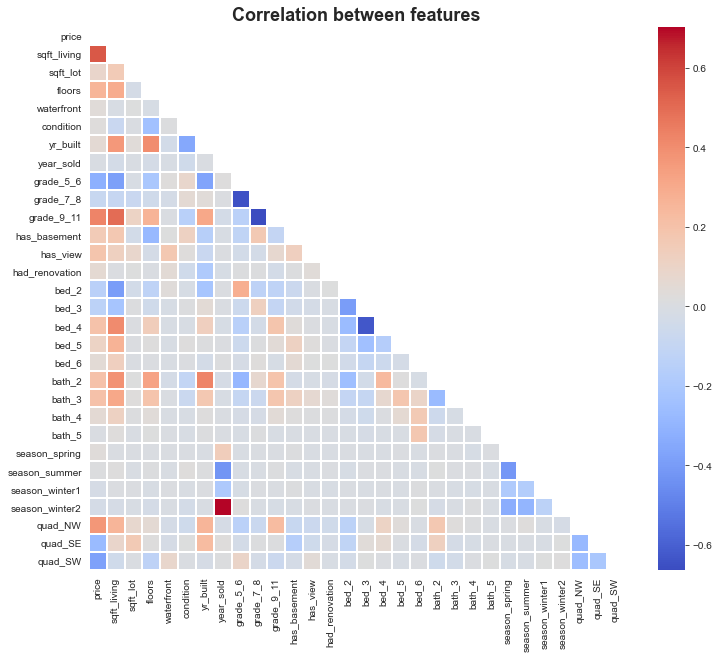

In [4]:
corr = df.corr()

plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df.corr(), cmap= 'coolwarm', mask= mask, linewidths= 1)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

Let's see which features have the highest correlations.

In [5]:
df_corr_stack = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr_stack['pairs'] = list(zip(df_corr_stack.level_0, df_corr_stack.level_1))

df_corr_stack.set_index(['pairs'], inplace= True)

df_corr_stack.drop(columns= ['level_1', 'level_0'], inplace= True)
df_corr_stack.columns = ['cc']

df_corr_stack.drop_duplicates(inplace= True)

df_corr_stack[(df_corr_stack.cc > .55) & (df_corr_stack.cc < 1)]

,cc
pairs,
"(season_winter2, year_sold)",0.703979
"(grade_7_8, grade_9_11)",0.663331
"(grade_7_8, grade_5_6)",0.645486
"(bed_3, bed_4)",0.627719
"(sqft_living, price)",0.554367


#### Stepwise Selection

In [6]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        if not changed:
            break
    return included

In [7]:
# Comment out to reduce scrolling
y = df['price']
X = df.drop('price', axis= 1)

result = stepwise_selection(X, y, verbose= True)
print ('resulting features:')
print (result)

<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  grade_9_11                     with p-value 0.0
Add  grade_7_8                      with p-value 0.0


<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sqft_living                    with p-value 0.0
Add  yr_built                       with p-value 0.0


<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  quad_NW                        with p-value 0.0
Add  quad_SW                        with p-value 0.0


<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  quad_SE                        with p-value 0.0
Add  has_view                       with p-value 3.25501e-115


<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  floors                         with p-value 4.61511e-64
Add  condition                      with p-value 1.85812e-57


<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sqft_lot                       with p-value 1.22318e-35
Add  waterfront                     with p-value 1.17918e-29


<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  year_sold                      with p-value 1.60249e-21
Add  bed_5                          with p-value 9.73629e-13


<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  bath_2                         with p-value 6.06989e-10
Add  bath_3                         with p-value 2.23582e-11


<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  bed_2                          with p-value 3.13954e-10
Add  season_winter2                 with p-value 1.71149e-08


<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  had_renovation                 with p-value 2.13784e-07
Add  bed_6                          with p-value 4.49425e-06


<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-6-657cd6eaff8a>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  bed_4                          with p-value 8.82972e-05
resulting features:
['grade_9_11', 'grade_7_8', 'sqft_living', 'yr_built', 'quad_NW', 'quad_SW', 'quad_SE', 'has_view', 'floors', 'condition', 'sqft_lot', 'waterfront', 'year_sold', 'bed_5', 'bath_2', 'bath_3', 'bed_2', 'season_winter2', 'had_renovation', 'bed_6', 'bed_4']


The stepwise selection function suggested the following features:


|           |            |           |            |        |          |         |            |
|-----------|------------|-----------|------------|--------|----------|---------|------------|
|grade_5_6| yr_built |quad_SW|condition|sqft_living|bed_5 |bed_2   |had_renovation|
|grade_7_8| year_sold|quad_SE|floors   |sqft_lot   |bed_6 |bath_2|season_winter2 | 
|grade_9_11|yr_built |quad_NW|has_view|waterfront |bed_4 |bath_3  | |


#### Variance Inflation Factor

In [8]:
# check VIF (variance inflation factor)
# Consider removing features with VIF > 5 

X = df.drop('price', axis= 1)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

vif_data['VIF'] = [vif(X.values, i) for i in range(len(X.columns))]

print (vif_data[vif_data['VIF'] >= 5])

        feature           VIF
0   sqft_living     25.743764
2        floors     13.464607
4     condition     35.524428
5      yr_built  10668.548798
6     year_sold  11159.925901
7     grade_5_6     82.628847
8     grade_7_8    537.257801
9    grade_9_11     89.314603
13        bed_2     15.659266
14        bed_3     53.404760
15        bed_4     34.339096
16        bed_5      7.879977


Stepwise Selection thought we could use some columns based on a low p-value. Variance Inflation Factor looked at the collinearity among the features. We will have to carefully consider both.

## Model 1: Has Everything

Only feature selection and engineering changes applied to baseline

In [9]:
y = df['price']
X = df.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 42)
df_train = pd.concat([X_train, y_train], axis= 1)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(14188, 29) (14188,)
(4730, 29) (4730,)


In [10]:
y = df['price']
X = df.drop('price', axis= 1)

X_int = sm.add_constant(X)
model= sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     1306.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:38:16   Log-Likelihood:            -2.4438e+05
No. Observations:               18918   AIC:                         4.888e+05
Df Residuals:                   18888   BIC:                         4.891e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.262e+07   5.25e+06     -8.121      0.000   -5.29e+07   -3.23e+07
sqft_living      106.4852      1.805     59.008      0.000     102.948     110.022
sqft_lot           0.2805      0.023     12.142      0.000       0.235       0.326
floors           2.53e+04   1637.923     15.448      0.000    2.21e+04    2.85e+04
waterfront      1.791e+05   1.62e+04     11.086      0.000    1.47e+05    2.11e+05
condition       2.146e+04   1235.799     17.364      0.000     1.9e+04    2.39e+04
yr_built        -970.3282     37.607    -25.802      0.000   -1044.042    -896.615
year_sold       2.215e+04   2605.572      8.500      0.000     1.7e+04    2.73e+04
grade_5_6       1.188e+04   1.91e+04      0.623      0.533   -2.55e+04    4.92e+04
grade_7_8       8.676e+04   1.91e+04      4.543      0.000    4.93e+04    1.24e+05
grade_9_11      1.835e+05   1.93e+04      9.487      0.000    1.46e+05    2.21e+05
has_basement    2259.3200   1784.664      1.266      0.206   -1238.781    5757.421
has_view        6.085e+04   3033.277     20.061      0.000    5.49e+04    6.68e+04
had_renovation  2.283e+04   4553.712      5.014      0.000    1.39e+04    3.18e+04
bed_2           1.345e+04   7549.929      1.782      0.075   -1346.250    2.83e+04
bed_3           -154.0174   7533.999     -0.020      0.984   -1.49e+04    1.46e+04
bed_4          -7362.3892   7736.245     -0.952      0.341   -2.25e+04    7801.344
bed_5          -2.968e+04   8297.028     -3.577      0.000   -4.59e+04   -1.34e+04
bed_6          -4.141e+04   1.09e+04     -3.805      0.000   -6.27e+04   -2.01e+04
bath_2          1.778e+04   2016.122      8.821      0.000    1.38e+04    2.17e+04
bath_3          2.449e+04   3666.526      6.679      0.000    1.73e+04    3.17e+04
bath_4          5727.6407   1.27e+04      0.449      0.653   -1.93e+04    3.07e+04
bath_5           5.25e+04   4.11e+04      1.277      0.202   -2.81e+04    1.33e+05
season_spring   4898.6874   2499.960      1.960      0.050      -1.459    9798.834
season_summer   5363.6264   2293.968      2.338      0.019     867.243    9860.010
season_winter1 -3345.4119   3299.604     -1.014      0.311   -9812.931    3122.108
season_winter2 -9516.0245   3582.545     -2.656      0.008   -1.65e+04   -2493.916
quad_NW         1.647e+04   2172.422      7.582      0.000    1.22e+04    2.07e+04
quad_SE         -1.56e+05   2429.190    -64.210      0.000   -1.61e+05   -1.51e+05
quad_SW        -1.812e+05   2302.813    -78.665      0.000   -1.86e+05   -1.77e+05
==============================================================================
Omnibus:                      613.830   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              936.569
Skew:                           0.319   Prob(JB):                    4.23e-204
Kurtosis:                   

### RMSE & Accuracy

In [11]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  98029.48750071184
Test RMSE:  100431.74421033513


In [12]:
# Find accuracy of test and train sets
# Accuracy is % of predictions it got correct
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  66.87334262848775
Accuracy score - test: 66.25624732706463


### Q-Q Plot

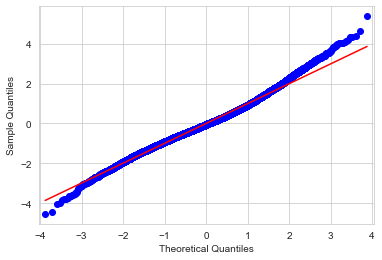

In [13]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig.show()

That Q-Q plot shows we have some thin 'tails' on our data.

While this model looks better than the baseline on a Q-Q plot and gives an okay $R^2$ value, we have to remember it doesn't meet the assumption of having little to no multicollinearity and still has features that are not statistically significant.

## Model 2: Remove Almost Everything
Select features suggested by stepwise selection function while removing those that may cause multicollinearity indicated by VIF.

In [14]:
df1 = df[['price', 'quad_NW', 'quad_SW', 'quad_SE','has_view', 'floors', 
          'condition', 'sqft_lot', 'waterfront', 'bed_5', 'bath_2', 'bath_3', 
          'had_renovation', 'bed_6', 'bed_4']]

In [15]:
y = df1['price']
X = df1.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 42)
df_train1 = pd.concat([X_train, y_train], axis= 1)

In [16]:
y = df_train1['price']
X = df_train1.drop('price', axis= 1)

X_int = sm.add_constant(X)
model1= sm.OLS(y, X_int).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     949.5
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:38:16   Log-Likelihood:            -1.8634e+05
No. Observations:               14188   AIC:                         3.727e+05
Df Residuals:                   14173   BIC:                         3.728e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.724e+05   7134.800     38.179      0.000    2.58e+05    2.86e+05
quad_NW         4.316e+04   2742.329     15.738      0.000    3.78e+04    4.85e+04
quad_SW        -1.893e+05   3111.017    -60.856      0.000   -1.95e+05   -1.83e+05
quad_SE        -1.624e+05   3052.141    -53.203      0.000   -1.68e+05   -1.56e+05
has_view        1.109e+05   4292.179     25.828      0.000    1.02e+05    1.19e+05
floors          3.642e+04   2084.058     17.476      0.000    3.23e+04    4.05e+04
condition        2.59e+04   1655.964     15.640      0.000    2.27e+04    2.91e+04
sqft_lot           0.6268      0.033     19.103      0.000       0.562       0.691
waterfront      1.722e+05   2.21e+04      7.784      0.000    1.29e+05    2.16e+05
bed_5           6.231e+04   4606.231     13.526      0.000    5.33e+04    7.13e+04
bath_2          6.467e+04   2490.466     25.966      0.000    5.98e+04    6.95e+04
bath_3          1.131e+05   4710.881     24.013      0.000    1.04e+05    1.22e+05
had_renovation  4.629e+04   6362.737      7.275      0.000    3.38e+04    5.88e+04
bed_6           6.493e+04   1.03e+04      6.324      0.000    4.48e+04    8.51e+04
bed_4           5.729e+04   2425.524     23.620      0.000    5.25e+04     6.2e+04
==============================================================================
Omnibus:                      363.866   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              402.588
Skew:                           0.375   Prob(JB):                     3.79e-88
Kurtosis:                       3.343   Cond. No.                     7.58e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ouch! Felt that right in the $R^2$! Most of the calculation's scores dropped - some more significantly than others. Kurtosis is fairly close to 3 now - indicating it is almost normally distributed. The Jarque-Bera (JB) (another normality test) is almost half of what it was in the first model.

### RMSE & Accuracy

In [17]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  122348.38023464952
Test RMSE:  124213.70311848255


In [18]:
# Find accuracy of test and train sets
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  48.39870513827644
Accuracy score - test: 48.38328192050325


### Q-Q Plot

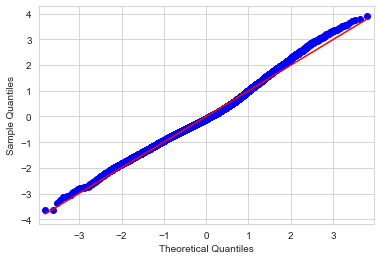

In [52]:
residuals = model1.resid
fig1 = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig1.show()

### Correlation Matrix

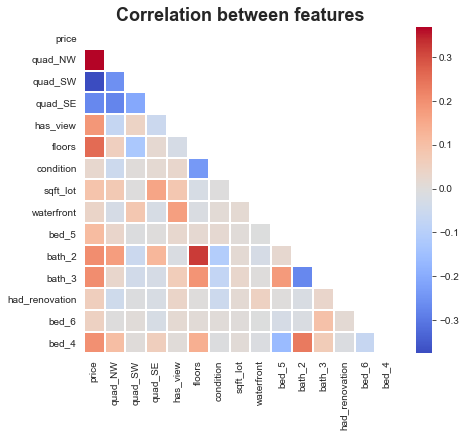

In [59]:
corr = df1.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df1.corr(), cmap= 'coolwarm', mask= mask, linewidths= 1)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

While this model meets normality assumptions better than the other model, it is does a poorer job at predicting housing prices.

## Model 3:  Meet in the Middle
Find a model that can predict well and meet most normality assumptions

In [20]:
df2 = df[['price', 'has_view', 'condition', 'waterfront', 'floors', 
          'grade_5_6', 'grade_9_11', 'quad_SE', 'quad_SW', 'yr_built', 
          'sqft_living', 'bath_2', 'bed_5', 'sqft_lot', 'bed_2', 
          'had_renovation']]

In [21]:
y = df2['price']
X = df2.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                    random_state = 42)
df_train2 = pd.concat([X_train, y_train], axis= 1)

In [22]:
y = df_train2['price']
X = df_train2.drop('price', axis= 1)

X_int = sm.add_constant(X)
model2 = sm.OLS(y, X_int).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     1858.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:38:16   Log-Likelihood:            -1.8332e+05
No. Observations:               14188   AIC:                         3.667e+05
Df Residuals:                   14172   BIC:                         3.668e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.779e+06   7.92e+04     22.472      0.000    1.62e+06    1.93e+06
has_view        5.923e+04   3495.914     16.943      0.000    5.24e+04    6.61e+04
condition       2.178e+04   1419.795     15.343      0.000     1.9e+04    2.46e+04
waterfront      1.922e+05   1.79e+04     10.746      0.000    1.57e+05    2.27e+05
floors          2.453e+04   1694.609     14.475      0.000    2.12e+04    2.79e+04
grade_5_6       -7.16e+04   2989.027    -23.953      0.000   -7.75e+04   -6.57e+04
grade_9_11      9.544e+04   3036.476     31.430      0.000    8.95e+04    1.01e+05
quad_SE        -1.671e+05   2349.128    -71.124      0.000   -1.72e+05   -1.62e+05
quad_SW        -1.905e+05   2396.797    -79.488      0.000   -1.95e+05   -1.86e+05
yr_built        -816.8656     39.787    -20.531      0.000    -894.854    -738.877
sqft_living      109.3875      1.719     63.644      0.000     106.019     112.756
bath_2          1.161e+04   1961.353      5.917      0.000    7761.399    1.55e+04
bed_5          -2.185e+04   3736.484     -5.848      0.000   -2.92e+04   -1.45e+04
sqft_lot           0.3200      0.027     12.044      0.000       0.268       0.372
bed_2           1.263e+04   2674.636      4.722      0.000    7386.530    1.79e+04
had_renovation  2.174e+04   5296.984      4.104      0.000    1.14e+04    3.21e+04
==============================================================================
Omnibus:                      455.209   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.054
Skew:                           0.312   Prob(JB):                    3.56e-153
Kurtosis:                       3.893   Cond. No.                     3.35e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### RMSE & Accuracy

In [23]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  98880.70329606616
Test RMSE:  100884.39335475277


In [24]:
# Find accuracy of test and train sets
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  66.29554997122385
Accuracy score - test: 65.95139349250971


### Q-Q Plot

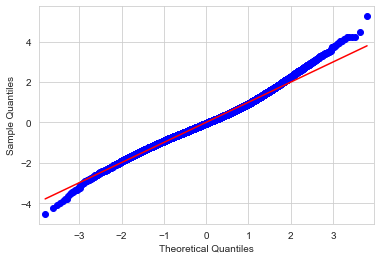

In [53]:
residuals = model2.resid
fig2 = sm.graphics.qqplot(residuals, dist= stats.norm, line= 'r', fit= True)
fig2.show()

Similar RMSE and accuracy in predictions as first model, but achieved while respecting normality assumptions.

## Model 4: Log Transform Model 3 

In [26]:
df3 = df2.copy()

In [27]:
df3.columns

Index(['price', 'has_view', 'condition', 'waterfront', 'floors', 'grade_5_6',
       'grade_9_11', 'quad_SE', 'quad_SW', 'yr_built', 'sqft_living', 'bath_2',
       'bed_5', 'sqft_lot', 'bed_2', 'had_renovation'],
      dtype='object')

In [28]:
# list of continuous features to log transform
cont = ['yr_built', 'sqft_living', 'sqft_lot']

In [29]:
df_cont = df2[cont]

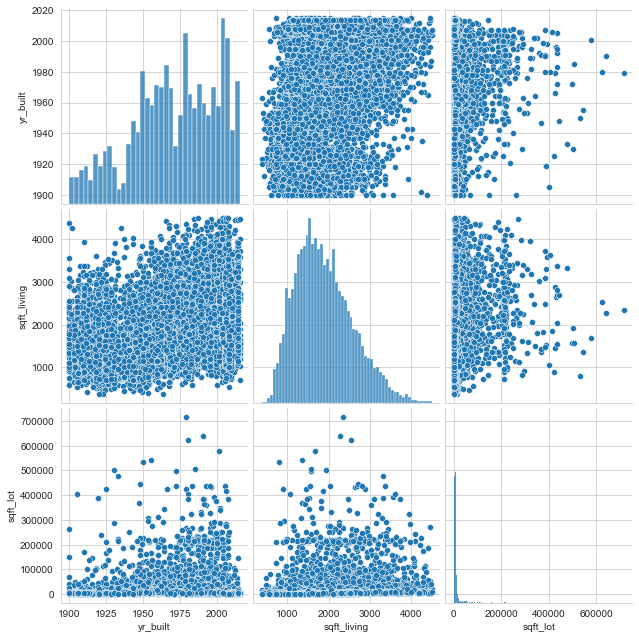

In [30]:
cont_pp = sns.pairplot(df_cont, height= 3)

Yikes. "sqft_living" is the only semi-normalish distribution.

In [31]:
log_names = [f'{column}_log' for column in df_cont.columns]

df_cont_log = np.log(df_cont)
df_cont_log.columns = log_names

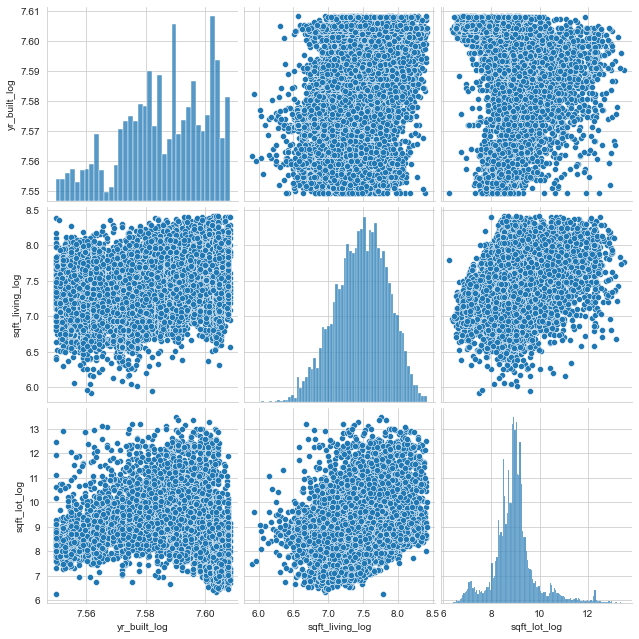

In [32]:
cont_pp2 = sns.pairplot(df_cont_log, height= 3)

"sqft_living" looks better and so does "sqft_lot". "yr_built" is still a bit messy, but better.

In [33]:
model4_log = pd.concat([df_cont_log, df3], axis= 1)
model4_log.head()

,yr_built_log,sqft_living_log,sqft_lot_log,price,has_view,condition,waterfront,floors,grade_5_6,grade_9_11,quad_SE,quad_SW,yr_built,sqft_living,bath_2,bed_5,sqft_lot,bed_2,had_renovation
0,7.578145,7.073270,8.639411,221900.0,0,3,0,1,0,0,0,0,1955,1180,0,0,5650,0,0
1,7.576097,7.851661,8.887653,538000.0,0,3,0,2,0,0,0,0,1951,2570,1,0,7242,0,1
2,7.566828,6.646391,9.210340,180000.0,0,3,0,1,1,0,0,0,1933,770,0,0,10000,1,0
3,7.583248,7.580700,8.517193,604000.0,0,5,0,1,0,0,0,0,1965,1960,0,0,5000,0,0
4,7.594381,7.426549,8.997147,510000.0,0,3,0,1,0,0,0,0,1987,1680,1,0,8080,0,0


In [34]:
model4_log.drop(columns= ['yr_built', 'sqft_living', 'sqft_lot'], 
                inplace= True)

### Train, test split

In [35]:
y = model4_log['price']
X = model4_log.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 42)
df_train3 = pd.concat([X_train, y_train], axis= 1)

In [36]:
y = df_train3['price']
X = df_train3.drop('price', axis= 1)

X_int = sm.add_constant(X)
model3 = sm.OLS(y, X_int).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     1834.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:38:22   Log-Likelihood:            -1.8338e+05
No. Observations:               14188   AIC:                         3.668e+05
Df Residuals:                   14172   BIC:                         3.669e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.021e+07   5.97e+05     17.115      0.000    9.04e+06    1.14e+07
yr_built_log    -1.506e+06   7.86e+04    -19.151      0.000   -1.66e+06   -1.35e+06
sqft_living_log  2.012e+05   3390.669     59.349      0.000    1.95e+05    2.08e+05
sqft_lot_log     9329.1443   1144.173      8.154      0.000    7086.416    1.16e+04
has_view         6.258e+04   3502.713     17.866      0.000    5.57e+04    6.94e+04
condition        2.057e+04   1426.382     14.420      0.000    1.78e+04    2.34e+04
waterfront       1.829e+05    1.8e+04     10.168      0.000    1.48e+05    2.18e+05
floors           2.773e+04   1818.184     15.253      0.000    2.42e+04    3.13e+04
grade_5_6       -5.698e+04   3077.051    -18.518      0.000    -6.3e+04    -5.1e+04
grade_9_11       1.107e+05   2970.627     37.273      0.000    1.05e+05    1.17e+05
quad_SE         -1.667e+05   2410.286    -69.167      0.000   -1.71e+05   -1.62e+05
quad_SW         -1.931e+05   2433.921    -79.335      0.000   -1.98e+05   -1.88e+05
bath_2           4825.4528   1993.663      2.420      0.016     917.612    8733.294
bed_5            -1.41e+04   3719.584     -3.792      0.000   -2.14e+04   -6813.161
bed_2            2.654e+04   2749.218      9.655      0.000    2.12e+04    3.19e+04
had_renovation   2.372e+04   5319.213      4.460      0.000    1.33e+04    3.41e+04
==============================================================================
Omnibus:                      406.327   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              585.037
Skew:                           0.306   Prob(JB):                    9.14e-128
Kurtosis:                       3.785   Cond. No.                     1.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### RMSE & Accuracy

In [37]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  99320.24255225611
Test RMSE:  101760.54191516987


In [38]:
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  65.99524152766111
Accuracy score - test: 65.35742299467833


### Q-Q Plot

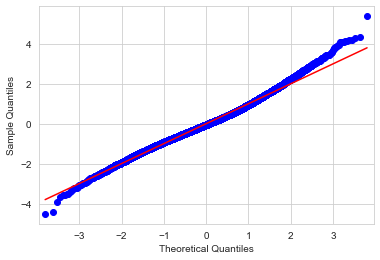

In [54]:
# Q-Q plot
residuals = model3.resid
fig3 = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig3.show()

The "tails" on the Q-Q plot are closer to normal, but the model is not any better at predicting house prices than the model without a log transformation. Let's use the model that hasn't been log-transformed going forward to easily understand the features.

## Model 5: Remove Outliers 
AKA: Fix those tails!

In [40]:
df5 = df[['price', 'has_view', 'condition', 'waterfront', 'floors', 
          'grade_5_6', 'grade_9_11', 'quad_SE', 'quad_SW', 'yr_built', 
          'sqft_living', 'bed_5', 'sqft_lot', 'bed_2', 'bath_2',
          'had_renovation']]

In [41]:
# Remove everything after 3 standard deviations
df5 = df5[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [42]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13951 entries, 0 to 18917
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           13951 non-null  float64
 1   has_view        13951 non-null  int64  
 2   condition       13951 non-null  int64  
 3   waterfront      13951 non-null  int64  
 4   floors          13951 non-null  int64  
 5   grade_5_6       13951 non-null  int64  
 6   grade_9_11      13951 non-null  int64  
 7   quad_SE         13951 non-null  int64  
 8   quad_SW         13951 non-null  int64  
 9   yr_built        13951 non-null  int64  
 10  sqft_living     13951 non-null  int64  
 11  bed_5           13951 non-null  int64  
 12  sqft_lot        13951 non-null  int64  
 13  bed_2           13951 non-null  int64  
 14  bath_2          13951 non-null  int64  
 15  had_renovation  13951 non-null  int64  
dtypes: float64(1), int64(15)
memory usage: 1.8 MB


We lost quite a bit of data doing that. We started at 18,918 and we are now at 13,951.

In [43]:
# Don't have data in these columns after everything 
# outside of 3 stds was removed
print('bed_5:', df5.bed_5.unique())
print ('has_view:', df5.has_view.unique())
print ('had_renovation:', df5.had_renovation.unique())
print ('waterfront', df5.waterfront.unique())

bed_5: [0]
has_view: [0]
had_renovation: [0]
waterfront [0]


In [44]:
# drop those columns
df5 = df5.drop(columns= ['bed_5', 'had_renovation', 'has_view', 'waterfront'])

Having fewer data points may affect our model. Let's see!

In [45]:
y = df5['price']
X = df5.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 42)
df_train5 = pd.concat([X_train, y_train], axis= 1)

In [46]:
y = df_train5['price']
X = df_train5.drop('price', axis= 1)

X_int = sm.add_constant(X)
model5 = sm.OLS(y, X_int).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     1870.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:38:23   Log-Likelihood:            -1.3468e+05
No. Observations:               10463   AIC:                         2.694e+05
Df Residuals:                   10451   BIC:                         2.695e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.054e+06    9.1e+04     22.581      0.000    1.88e+06    2.23e+06
condition    2.119e+04   1578.559     13.425      0.000    1.81e+04    2.43e+04
floors       2.015e+04   1993.151     10.110      0.000    1.62e+04    2.41e+04
grade_5_6   -7.247e+04   3172.843    -22.840      0.000   -7.87e+04   -6.62e+04
grade_9_11   9.516e+04   3630.594     26.210      0.000     8.8e+04    1.02e+05
quad_SE     -1.663e+05   2574.993    -64.601      0.000   -1.71e+05   -1.61e+05
quad_SW     -1.901e+05   2667.820    -71.258      0.000   -1.95e+05   -1.85e+05
yr_built     -957.3349     45.680    -20.957      0.000   -1046.876    -867.793
sqft_living   111.2186      2.213     50.262      0.000     106.881     115.556
sqft_lot        0.5415      0.089      6.107      0.000       0.368       0.715
bed_2         1.25e+04   2853.582      4.381      0.000    6909.078    1.81e+04
bath_2        1.94e+04   2565.082      7.561      0.000    1.44e+04    2.44e+04
==============================================================================
Omnibus:                      358.285   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.832
Skew:                           0.349   Prob(JB):                    9.74e-113
Kurtosis:                       3.834   Cond. No.                     1.46e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### RMSE & Accuracy

In [47]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  94231.45706219051
Test RMSE:  94752.35910714709


In [48]:
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  66.30652254001429
Accuracy score - test: 65.74768242466615


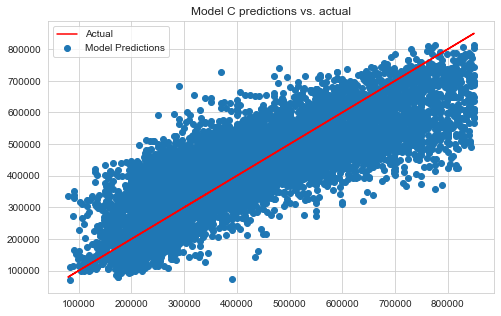

In [57]:
# Get predictions
y_pred = linreg.predict(X_train)

# Create a matplotlib figure
plt.figure(figsize=(8, 5))
# Create a scatter plot
plt.scatter(y_train, y_pred, label='Model Predictions')
plt.plot(y_train, y_train, label='Actual', color='r')
plt.title('Model 5 Predictions vs. Actual')
plt.legend()
plt.show()

### Q-Q Plot

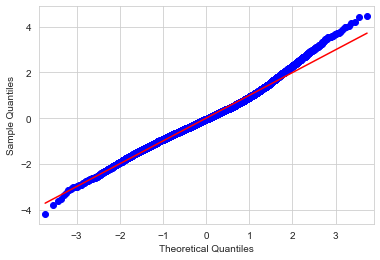

In [49]:
residuals = model5.resid
fig5 = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig5.show()

### Check regression assumptions in error terms

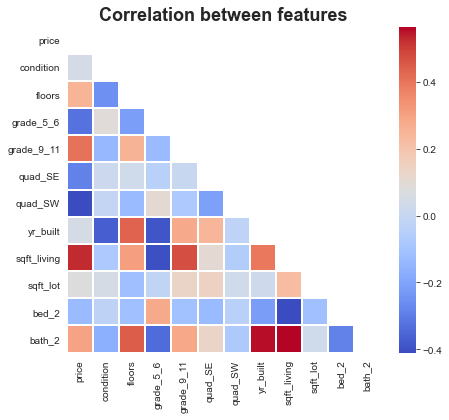

In [50]:
corr = df5.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df5.corr(), cmap= 'coolwarm', mask= mask, linewidths= 1)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

condition


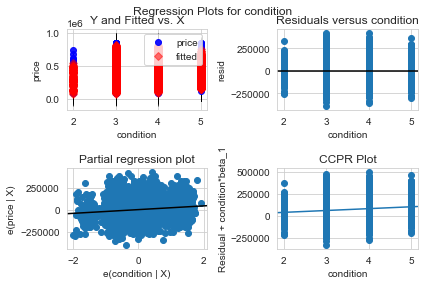

floors


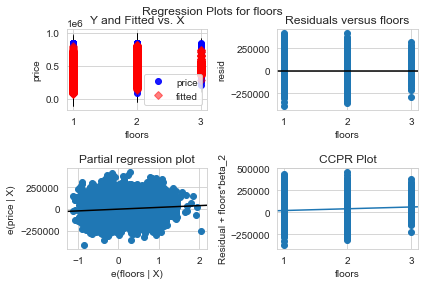

grade_5_6


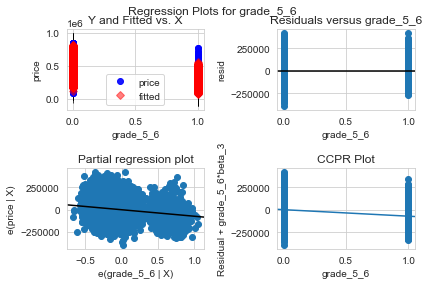

grade_9_11


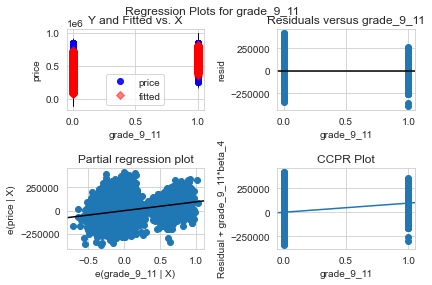

quad_SE


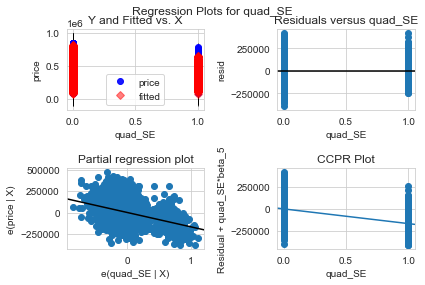

quad_SW


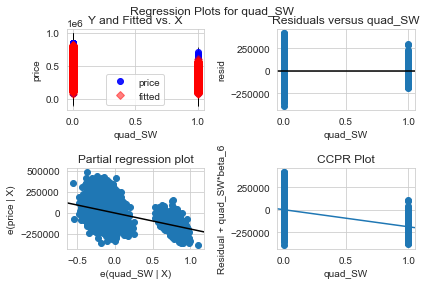

yr_built


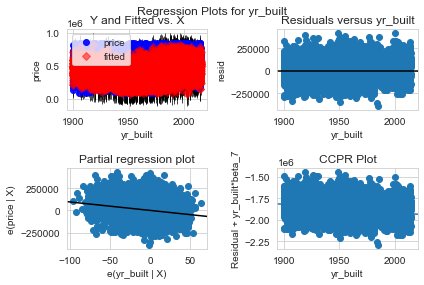

sqft_living


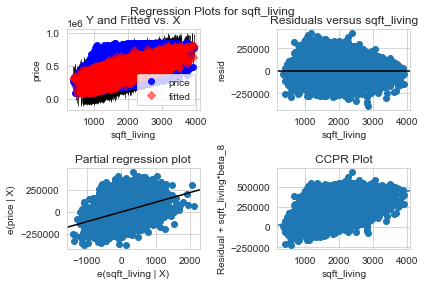

bath_2


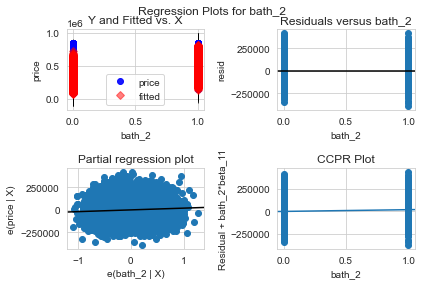

sqft_lot


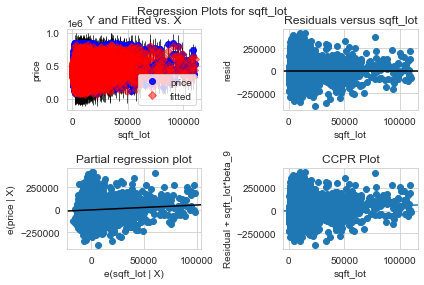

bed_2


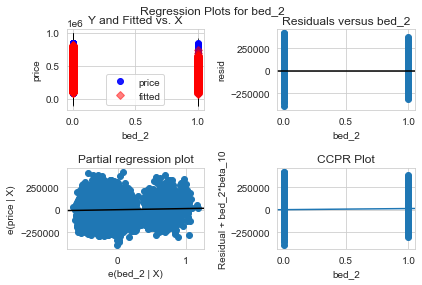

In [51]:
labels = ['condition', 'floors', 'grade_5_6', 'grade_9_11', 'quad_SE', 
          'quad_SW', 'yr_built', 'sqft_living', 'bath_2', 'sqft_lot', 'bed_2']

for ind, i in enumerate(labels):
    print (labels[ind])
    sm.graphics.plot_regress_exog(model5, i)
    plt.show()

## Conclusion

The models that do the best at predicting house sale prices for first time home buyers were the third and fifth models. Interestingly, these models did not need any normalization or log transformations to perform better.

Those models can accurately predict the price of a house 66% of the time. The fifth model without outliers is able to get closer to the actual price, within \\$94,231. The other model (the third) can predict the house sale price within \\$98,881. 

* Both models show a relationship between sale price and the year a house was built. One might expect a house's value to go down approximately \\$815-960 every year it gets older.

* The models also show that increasing the size of your home will increase the value. For every square foot of living space, one could expect an extra \\$110 on the sale price.

* Adding square footage to the lot does increase the value of property- about .32 or .54 cents for every square foot. That may not sound like a lot of money, but we kept lots that were up to 750,000 square feet. That can add up if you have a lot of land.

**_Recommendations to First Time Home Buyers:_**

* First time home buyers should make sure they are buying houses between the months of October through March to avoid paying more for the same house the in spring and summer months.

* They may also choose to look at homes south of longitude 47.5 if they are looking to spend less.

* Most houses have average or higher than average grades and conditions. Houses should be "move-in ready" in most cases.

* If the buyer is wanting extra features like properties with a view or on the water, they may have to wait longer or choose from a limited selection.

## Future Work

Other topics that would be good to evaluate in the future include: 
* Commute times
* Surrounding amenities such as schools, parks, restaurants, grocery stores, hospitals and other places of interest 
* Vicinity to public transportation or walk-ability
* Comparing to newer data
* Estimating other costs like home insurance and taxes